Note: Much code taken from Neuromatch NeuroAI 2024 Microlearning.

## Dependencies

In [24]:
# dependencies
from IPython.display import Image, SVG, display
import os
from pathlib import Path

import random
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torchvision
import contextlib
import io
from scipy.ndimage import uniform_filter1d

## Plotting and metrics imports
from metrics import get_plotting_color, plot_examples, plot_class_distribution, plot_results, plot_scores_per_class, plot_weights

## Other functions imports
from helpers import sigmoid, ReLU, add_bias, create_batches, calculate_accuracy, calculate_cosine_similarity, calculate_grad_snr

## MLP imports
from MLP import MLP, NodePerturbMLP, KolenPollackMLP

<module 'MLP' from 'd:\\MyFolders\\project\\2024summer\\NeuroAI\\NMA-Microlearning-Project\\MLP.py'>

## Data

In [9]:
# Download MNIST function
def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    
    rng_data = np.random.default_rng(seed=42)
    train_num = 50000
    shuffled_train_idx = rng_data.permutation(train_num)

    full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform)
    full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform)
    
    full_train_images = full_train_set.data.numpy().astype(float) / 255
    train_images = full_train_images[shuffled_train_idx[:train_num]].reshape((-1, 784)).T.copy()
    valid_images = full_train_images[shuffled_train_idx[train_num:]].reshape((-1, 784)).T.copy()
    test_images = (full_test_set.data.numpy().astype(float) / 255).reshape((-1, 784)).T

    full_train_labels = torch.nn.functional.one_hot(full_train_set.targets, num_classes=10).numpy()
    train_labels = full_train_labels[shuffled_train_idx[:train_num]].T.copy()
    valid_labels = full_train_labels[shuffled_train_idx[train_num:]].T.copy()
    test_labels = torch.nn.functional.one_hot(full_test_set.targets, num_classes=10).numpy().T

    train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set, [train_prop * keep_prop, valid_prop * keep_prop, discard_prop])
    test_set, _ = torch.utils.data.random_split(
      full_test_set, [keep_prop, discard_prop])

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels

In [10]:
train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels = download_mnist()

Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


## Hyperparams

In [11]:
#HYPERPARAMETERS
NUM_INPUTS = 784
NUM_OUTPUTS = 10
numhidden = 500
batchsize = 128
initweight = 0.1
learnrate = 0.001
noise = 0.1
numepochs = 25
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report = True
rep_rate = 1
seed = 12345

In [5]:
# set random seed
rng = np.random.default_rng(seed=seed)

indices = np.random.choice(test_images.shape[1], size=1000, replace=False)

## Backprop

In [7]:
# Normal learning
netbackprop = MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_bp_normal, accuracy_bp_normal, test_loss_bp_normal, snr1_bp_normal, snr2_bp_normal, cosine_similarity_bp_normal) = \
    netbackprop.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=rep_rate)

Training starting...
...completed  1.0  epochs of training. Current loss:  59.83
...completed  2.0  epochs of training. Current loss:  57.78
...completed  3.0  epochs of training. Current loss:  56.73
...completed  4.0  epochs of training. Current loss:  56.09
...completed  5.0  epochs of training. Current loss:  55.66
...completed  6.0  epochs of training. Current loss:  55.35
...completed  7.0  epochs of training. Current loss:  55.12
...completed  8.0  epochs of training. Current loss:  54.93
...completed  9.0  epochs of training. Current loss:  54.78
...completed  10.0  epochs of training. Current loss:  54.66
...completed  11.0  epochs of training. Current loss:  54.55
...completed  12.0  epochs of training. Current loss:  54.46
...completed  13.0  epochs of training. Current loss:  54.38
...completed  14.0  epochs of training. Current loss:  54.31
...completed  15.0  epochs of training. Current loss:  54.25
...completed  16.0  epochs of training. Current loss:  54.19
...completed

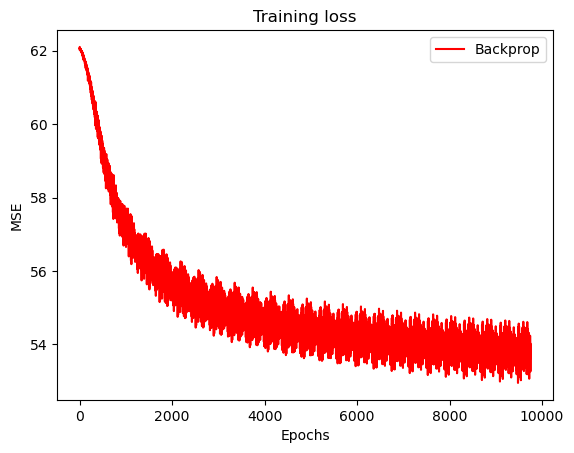

In [8]:
plt.plot(losses_bp_normal, label="Backprop", color='r')

plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()

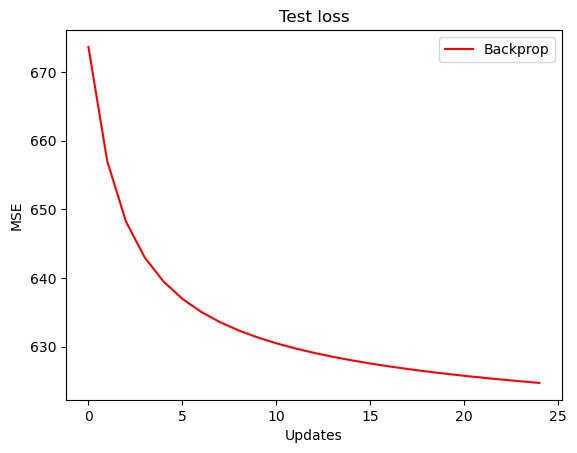

In [9]:
plt.plot(test_loss_bp_normal, label="Backprop", color='r')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Test loss")
plt.show()

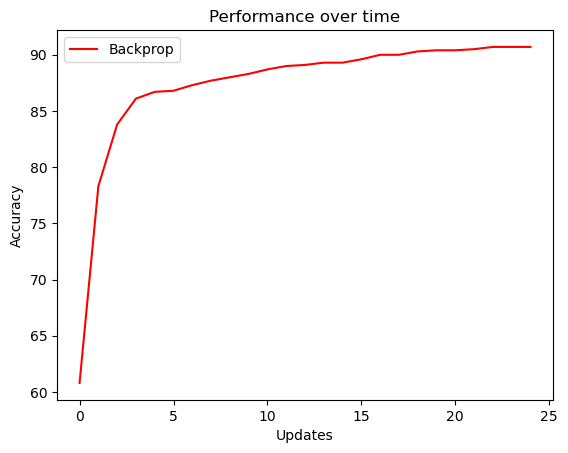

In [10]:
plt.plot(accuracy_bp_normal, label="Backprop", color='r')
plt.xlabel("Updates")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Performance over time")
plt.show()

In [13]:
# Online learning
from MLP import MLP, NodePerturbMLP, KolenPollackMLP

net_bp_online = MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_bp_online, accuracy_bp_online, test_loss_bp_online, snr1_bp_online, snr2_bp_online, cosine_similarity_bp_online) = \
(losses_bp_online, accuracy_bp_online, test_loss_bp_online, snr1_bp_online, snr2_bp_online, cosine_similarity_bp_online) = \
    net_bp_online.train_online(rng, train_images, train_labels, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=0.01, max_it=numupdates*batchsize, conv_loss = 1e-1, algorithm='backprop', noise=noise, \
                      report=report, report_rate=batchsize)

Training starting...
...completed  50000  iterations (corresponding to 1 epoch) of training data (single images). Current loss:  0.9419 .


In [13]:
# Noisy Input
# create a network and train it using backprop
netbackprop_noisy = MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_bp_noisy, accuracy_bp_noisy, test_loss_bp_noisy, snr1_bp_noisy, snr2_bp_noisy, cosine_similarity_bp_noisy) = \
    netbackprop_noisy.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      noise_type='gauss',report=report, report_rate=rep_rate)

Training starting...
...completed  1.0  epochs of training. Current loss:  60.55
...completed  2.0  epochs of training. Current loss:  58.61
...completed  3.0  epochs of training. Current loss:  57.42
...completed  4.0  epochs of training. Current loss:  56.71
...completed  5.0  epochs of training. Current loss:  56.23
...completed  6.0  epochs of training. Current loss:  55.88
...completed  7.0  epochs of training. Current loss:  55.62
...completed  8.0  epochs of training. Current loss:  55.41
...completed  9.0  epochs of training. Current loss:  55.24
...completed  10.0  epochs of training. Current loss:  55.09
...completed  11.0  epochs of training. Current loss:  54.97
...completed  12.0  epochs of training. Current loss:  54.86
...completed  13.0  epochs of training. Current loss:  54.77
...completed  14.0  epochs of training. Current loss:  54.68
...completed  15.0  epochs of training. Current loss:  54.61
...completed  16.0  epochs of training. Current loss:  54.54
...completed

FileNotFoundError: [Errno 2] No such file or directory: 'results/net_bp_online/losses_bp_normal.npy'

In [ ]:
# Non-Stationary Data
net_bp_nonstat = MLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_bp_nonstat, accuracy_bp_nonstat, test_loss_bp_nonstat, snr1_bp_nonstat, snr2_bp_nonstat, cosine_similarity_bp_nonstat) = \
    net_bp_nonstat.train_nonstat_data(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=1)

## FFA

In [31]:
# Normal Learning
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
netffa_online = net_ff_model.net_FF_model(rng)
(losses_ffa_online_ce, test_loss_ffa_online_ce, 
 losses_ffa_online_mse, test_loss_ffa_online_mse,
 accuracy_ffa_online) = netffa_online.train_online(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    max_it=150000, conv_loss=0.50, 
    report_rate=batchsize, lr=0.01,
    model='ff_com', return_loss='cross_entropy'
)

seed: 42
device: cpu
input:
  path: datasets
  batch_size: 128
model:
  peer_normalization: 0.03
  momentum: 0.9
  hidden_dim: 500
  num_layers: 2
training:
  epochs: 100
  learning_rate: 0.001
  weight_decay: 0
  momentum: 0
  downstream_learning_rate: 0.001
  downstream_weight_decay: 0
  val_idx: 0
  final_test: true

FF_model(
  (model): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=500, bias=True)
  )
  (ff_loss): BCEWithLogitsLoss()
  (linear_classifier): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=False)
  )
  (classification_loss): CrossEntropyLoss()
) 

...completed  1  iterations of training. 

                Current training cross_entropy loss:  0.06137740612030029, 

                Current testing accuracy:  0.113 

                Current testing loss:  4.456904888153076 
 
...completed  129  iterations of training. 

                Current training cross_entropy loss:  4.492

In [32]:
print(len(losses_ffa_online_ce), 
      len(test_loss_ffa_online_ce),
      len(losses_ffa_online_mse),
      len(test_loss_ffa_online_mse),
      len(accuracy_ffa_online)
      )
np.save('results/netffa/losses_ffa_online_ce.npy', np.asarray(losses_ffa_online_ce))
np.save('results/netffa/test_loss_ffa_online_ce.npy', np.asarray(test_loss_ffa_online_ce))
np.save('results/netffa/losses_ffa_online_mse.npy', np.asarray(losses_ffa_online_mse))
np.save('results/netffa/test_loss_ffa_online_mse.npy', np.asarray(test_loss_ffa_online_mse))
np.save('results/netffa/accuracy_ffa_online.npy', np.asarray(accuracy_ffa_online))

844 844 844 844 844


In [22]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
net_ffa_nonstat = net_ff_model.net_FF_model(rng)
(losses_ffa_nonstat_ce, test_loss_ffa_nonstat_ce, 
 losses_ffa_nonstat_mse, test_loss_ffa_nonstat_mse,
 accuracy_ffa_nonstat) = net_ffa_nonstat.train_nonstationary(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    epochs=numepochs, model='ff_com', return_loss='cross_entropy'
)

seed: 42
device: cpu
input:
  path: datasets
  batch_size: 128
model:
  peer_normalization: 0.03
  momentum: 0.9
  hidden_dim: 500
  num_layers: 2
training:
  epochs: 100
  learning_rate: 0.001
  weight_decay: 0
  momentum: 0
  downstream_learning_rate: 0.001
  downstream_weight_decay: 0
  val_idx: 0
  final_test: true

FF_model(
  (model): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=500, bias=True)
  )
  (ff_loss): BCEWithLogitsLoss()
  (linear_classifier): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=False)
  )
  (classification_loss): CrossEntropyLoss()
) 

...completed  0  epochs of training. 

            Current innate loss:  54.250599748599605, 

            Current training cross_entropy loss:  1.1063182309547566, 

            Current testing cross_entropy loss:  3.121723175048828, 
   
            Current testing accuracy:  0.384 
         
            
...completed  1  epochs of

In [23]:
print(len(losses_ffa_nonstat_ce), 
      len(test_loss_ffa_nonstat_ce),
      len(losses_ffa_nonstat_mse),
      len(test_loss_ffa_nonstat_mse),
      len(accuracy_ffa_nonstat)
      )
np.save('results/netffa/losses_ffa_nonstat_ce.npy', np.asarray(losses_ffa_nonstat_ce))
np.save('results/netffa/test_loss_ffa_nonstat_ce.npy', np.asarray(test_loss_ffa_nonstat_ce))
np.save('results/netffa/losses_ffa_nonstat_mse.npy', np.asarray(losses_ffa_nonstat_mse))
np.save('results/netffa/test_loss_ffa_nonstat_mse.npy', np.asarray(test_loss_ffa_nonstat_mse))
np.save('results/netffa/accuracy_ffa_nonstat.npy', np.asarray(accuracy_ffa_nonstat))

4841 25 4841 25 25


In [25]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
net_ffa_noisy = net_ff_model.net_FF_model(rng)
(losses_ffa_noisy_ce, test_loss_ffa_noisy_ce, 
 losses_ffa_noisy_mse, test_loss_ffa_noisy_mse,
 accuracy_ffa_noisy) = net_ffa_noisy.train_noisydata(
    train_images, train_labels, 
    test_images[:, indices], test_labels[:, indices],
    epochs=numepochs, model='ff_com', return_loss='cross_entropy'
)

seed: 42
device: cpu
input:
  path: datasets
  batch_size: 128
model:
  peer_normalization: 0.03
  momentum: 0.9
  hidden_dim: 500
  num_layers: 2
training:
  epochs: 100
  learning_rate: 0.001
  weight_decay: 0
  momentum: 0
  downstream_learning_rate: 0.001
  downstream_weight_decay: 0
  val_idx: 0
  final_test: true

FF_model(
  (model): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=500, bias=True)
  )
  (ff_loss): BCEWithLogitsLoss()
  (linear_classifier): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=False)
  )
  (classification_loss): CrossEntropyLoss()
) 

...completed  0  epochs of training. 

            Current innate loss:  47.83585045154278, 

            Current training cross_entropy loss:  2.082044208049774, 

            Current testing cross_entropy loss:  1.601974368095398, 
   
            Current testing accuracy:  0.706 
         
            
...completed  1  epochs of t

In [26]:
print(len(losses_ffa_noisy_ce), 
      len(test_loss_ffa_noisy_ce),
      len(losses_ffa_noisy_mse),
      len(test_loss_ffa_noisy_mse),
      len(accuracy_ffa_noisy)
      )
np.save('results/netffa/losses_ffa_noisy_ce.npy', np.asarray(losses_ffa_noisy_ce))
np.save('results/netffa/test_loss_ffa_noisy_ce.npy', np.asarray(test_loss_ffa_noisy_ce))
np.save('results/netffa/losses_ffa_noisy_mse.npy', np.asarray(losses_ffa_noisy_mse))
np.save('results/netffa/test_loss_ffa_noisy_mse.npy', np.asarray(test_loss_ffa_noisy_mse))
np.save('results/netffa/accuracy_ffa_noisy.npy', np.asarray(accuracy_ffa_noisy))

9750 25 9750 25 25


## Node Perturbation

In [3]:
# Test
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/test/{filenames[i]}.csv", dtype=float, sep=","))

losses_node_perturb_test = data[0]
accuracy_node_perturb_test = data[1]
test_losses_node_perturb_test = data[2]
snr_node_perturb_test = data[3]
cosine_similarity_node_perturb_test = data[4]

In [ ]:
# Normal Learning
# to load the files again, in the main doc:
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/normal/{filenames[i]}.csv", dtype=float, sep=","))

losses_node_perturb_normal = data[0]
accuracy_node_perturb_normal = data[1]
test_losses_node_perturb_normal = data[2]
snr_node_perturb_normal = data[3]
cosine_similarity_node_perturb_normal = data[4]

In [ ]:
# Online Learning
# to load the files again, in the main doc:
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/online/{filenames[i]}.csv", dtype=float, sep=","))

losses_node_perturb_online = data[0]
accuracy_node_perturb_online = data[1]
test_losses_node_perturb_online = data[2]
snr_node_perturb_online = data[3]
cosine_similarity_node_perturb_online = data[4]

In [ ]:
# Noisy Input
# to load the files again, in the main doc:
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/noisy/{filenames[i]}.csv", dtype=float, sep=","))

losses_node_perturb_noisy = data[0]
accuracy_node_perturb_noisy = data[1]
test_losses_node_perturb_noisy = data[2]
snr_node_perturb_noisy = data[3]
cosine_similarity_node_perturb_noisy = data[4]

In [ ]:
# Non-Stationary Data
# to load the files again, in the main doc:
filenames= ["losses_node_perturb", "accuracy_node_perturb", "test_losses_node_perturb", "snr_node_perturb", "cosine_similarity_node_perturb"]

data = []

for i, name in enumerate(filenames):
  data.append(np.fromfile(f"data/node_perturb/non-stat/{filenames[i]}.csv", dtype=float, sep=","))

losses_node_perturb_non_stat = data[0]
accuracy_node_perturb_non_stat = data[1]
test_losses_node_perturb_non_stat = data[2]
snr_node_perturb_non_stat = data[3]
cosine_similarity_node_perturb_non_stat = data[4]

## Kolen-Pollack

In [18]:
# Normal Learning
netkolepoll = KolenPollackMLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_kp_normal, accuracy_kp_normal, test_loss_kp_normal, snr_kp_normal, cosine_similarity_kp_normal) = \
    netkolepoll.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=rep_rate)

rng = np.random.default_rng(seed=seed)

Training starting...
...completed  1.0  epochs of training. Current loss:  61.69
...completed  2.0  epochs of training. Current loss:  60.47
...completed  3.0  epochs of training. Current loss:  58.96
...completed  4.0  epochs of training. Current loss:  57.89
...completed  5.0  epochs of training. Current loss:  57.2
...completed  6.0  epochs of training. Current loss:  56.72
...completed  7.0  epochs of training. Current loss:  56.38
...completed  8.0  epochs of training. Current loss:  56.12
...completed  9.0  epochs of training. Current loss:  55.92
...completed  10.0  epochs of training. Current loss:  55.76
...completed  11.0  epochs of training. Current loss:  55.64
...completed  12.0  epochs of training. Current loss:  55.53
...completed  13.0  epochs of training. Current loss:  55.45
...completed  14.0  epochs of training. Current loss:  55.38
...completed  15.0  epochs of training. Current loss:  55.33
...completed  16.0  epochs of training. Current loss:  55.28
...completed 

In [ ]:
# Online Learning
net_kp_online = KolenPollackMLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_kp_online, accuracy_kp_online, test_loss_kp_online, snr_kp_online, cosine_similarity_kp_online) = \
    net_kp_online.train_online(rng, train_images, train_labels, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=0.01, max_it=numupdates*batchsize, conv_loss = 1e-1, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=batchsize)

In [19]:
# Noisy Input
net_kp_noisy = KolenPollackMLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_kp_noisy, accuracy_kp_noisy, test_loss_kp_noisy, snr_kp_noisy, cosine_similarity_kp_noisy) = \
    net_kp_noisy.train(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      noise_type='gauss',report=report, report_rate=rep_rate)

Training starting...
...completed  1.0  epochs of training. Current loss:  61.84
...completed  2.0  epochs of training. Current loss:  60.92
...completed  3.0  epochs of training. Current loss:  59.47
...completed  4.0  epochs of training. Current loss:  58.24
...completed  5.0  epochs of training. Current loss:  57.43
...completed  6.0  epochs of training. Current loss:  56.87
...completed  7.0  epochs of training. Current loss:  56.47
...completed  8.0  epochs of training. Current loss:  56.18
...completed  9.0  epochs of training. Current loss:  55.97
...completed  10.0  epochs of training. Current loss:  55.8
...completed  11.0  epochs of training. Current loss:  55.66
...completed  12.0  epochs of training. Current loss:  55.55
...completed  13.0  epochs of training. Current loss:  55.45
...completed  14.0  epochs of training. Current loss:  55.38
...completed  15.0  epochs of training. Current loss:  55.31
...completed  16.0  epochs of training. Current loss:  55.26
...completed 

In [ ]:
# Non-Stationary Data
net_kp_nonstat = KolenPollackMLP(rng, numhidden, sigma=initweight, activation=activation)
(losses_kp_nonstat, accuracy_kp_nonstat, test_loss_kp_nonstat, snr_kp_nonstat, cosine_similarity_kp_nonstat) = \
    net_kp_nonstat.train_nonstat_data(rng, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=1)

## Final Plots

In [ ]:
# if run without node perturb and ffa
# FFA
snr_ffa_normal, cosine_similarity_ffa_normal = [0], [0]
snr_ffa_online, cosine_similarity_ffa_online = [0], [0]
snr_ffa_noisy, cosine_similarity_ffa_noisy = [0], [0]
snr_ffa_nonstat, cosine_similarity_ffa_nonstat = [0], [0]

# Node Perturb
losses_np_normal, accuracy_np_normal, test_loss_np_normal, snr_np_normal, cosine_similarity_np_normal = [0], [0], [0], [0], [0]
losses_np_online, accuracy_np_online, test_loss_np_online, snr_np_online, cosine_similarity_np_online = [0], [0], [0], [0], [0]
losses_np_noisy, accuracy_np_noisy, test_loss_np_noisy, snr_np_noisy, cosine_similarity_np_noisy = [0], [0], [0], [0], [0]
losses_np_nonstat, accuracy_np_nonstat, test_loss_np_nonstat, snr_np_nonstat, cosine_similarity_np_nonstat = [0], [0], [0], [0], [0]


In [ ]:
# create arrays
# normal 
tr_loss_normal = [losses_bp_normal, losses_ffa_normal_ce, losses_np_normal, losses_kp_normal]
te_acc_normal = [accuracy_bp_normal, accuracy_ffa_normal, accuracy_np_normal, accuracy_kp_normal]
te_loss_normal = [test_loss_bp_normal, test_loss_ffa_normal_ce, test_loss_np_normal, test_loss_kp_normal]
snr_normal = [snr_bp_normal, snr_ffa_normal, snr_np_normal, snr_kp_normal]
cosine_similarity_normal = [cosine_similarity_bp_normal, cosine_similarity_ffa_normal, cosine_similarity_np_normal, cosine_similarity_kp_normal]

# online
# Calculate the moving average
window_size = 100
losses_bp_online_mean = uniform_filter1d(losses_bp_online, size=window_size)
losses_ffa_online_mean = uniform_filter1d(losses_ffa_online_ce, size=window_size)
losses_np_online_mean = uniform_filter1d(losses_np_online, size=window_size)
losses_kp_online_mean = uniform_filter1d(losses_kp_online, size=window_size)
tr_loss_online_mean = [losses_bp_online_mean, losses_ffa_online_mean, losses_np_online_mean, losses_kp_online_mean]

tr_loss_online = [losses_bp_online, losses_ffa_online_ce, losses_np_online, losses_kp_online]
te_acc_online = [accuracy_bp_online, accuracy_ffa_online, accuracy_np_online, accuracy_kp_online]
te_loss_online = [test_loss_bp_online, test_loss_ffa_online_ce, test_loss_np_online, test_loss_kp_online]
snr_online = [snr_bp_online, snr_ffa_online, snr_np_online, snr_kp_online]
cosine_similarity_online = [cosine_similarity_bp_online, cosine_similarity_ffa_online, cosine_similarity_np_online, cosine_similarity_kp_online]

# noisy
tr_loss_noisy = [losses_bp_noisy, losses_ffa_noisy_ce, losses_np_noisy, losses_kp_noisy]
te_acc_noisy = [accuracy_bp_noisy, accuracy_ffa_noisy, accuracy_np_noisy, accuracy_kp_noisy]
te_loss_noisy = [test_loss_bp_noisy, test_loss_ffa_noisy_ce, test_loss_np_noisy, test_loss_kp_noisy]
snr_noisy = [snr_bp_noisy, snr_ffa_noisy, snr_np_noisy, snr_kp_noisy]
cosine_similarity_noisy = [cosine_similarity_bp_noisy, cosine_similarity_ffa_noisy, cosine_similarity_np_noisy, cosine_similarity_kp_noisy]

# nonstat
tr_loss_nonstat = [losses_bp_nonstat, losses_ffa_nonstat, losses_np_nonstat, losses_kp_nonstat]
te_acc_nonstat = [accuracy_bp_nonstat, accuracy_ffa_nonstat, accuracy_np_nonstat, accuracy_kp_nonstat]
te_loss_nonstat = [test_loss_bp_nonstat, test_loss_ffa_nonstat_ce, test_loss_np_nonstat, test_loss_kp_nonstat]
snr_nonstat = [snr_bp_nonstat, snr_ffa_nonstat, snr_np_nonstat, snr_kp_nonstat]
cosine_similarity_nonstat = [cosine_similarity_bp_nonstat, cosine_similarity_ffa_nonstat, cosine_similarity_np_nonstat, cosine_similarity_kp_nonstat]

# algorithms
# algos = ['normal', 'online', 'noisy', 'nonstat']
algos = ['normal', 'noisy', 'nonstat']

In [ ]:
# plotting
for i, algo in enumerate(algos):
    if algo == 'normal':
        tr_loss, te_acc, te_loss, snr, cos_sim = tr_loss_normal, te_acc_normal, te_loss_normal, snr_normal, cosine_similarity_normal
    # elif algo == 'online':
    #     tr_loss, te_acc, te_loss, snr, cos_sim = tr_loss_online, te_acc_online, te_loss_online, snr_online, cosine_similarity_online
    elif algo == 'noisy':
        tr_loss, te_acc, te_loss, snr, cos_sim = tr_loss_noisy, te_acc_noisy, te_loss_noisy, snr_noisy, cosine_similarity_noisy
    elif algo == 'nonstat':
        tr_loss, te_acc, te_loss, snr, cos_sim = tr_loss_nonstat, te_acc_nonstat, te_loss_nonstat, snr_nonstat, cosine_similarity_nonstat
        
    # plot
    plt.figure(figsize=(30, 5))
    plt.subplot(151)

    plt.plot(tr_loss[0], label="Backprop", color='r')
    plt.plot(tr_loss[1], label="FFA", color='gold')
    plt.plot(tr_loss[2], label="Node Perturbation", color='c')
    plt.plot(tr_loss[3], label="Kolen-Pollack", color='k')
    
    plt.xlabel("Updates (every batch)")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Training loss")

    plt.subplot(152)
    plt.plot(te_acc[0], label="Backprop", color='r')
    plt.plot(te_acc[1], label="FFA", color='gold')
    plt.plot(te_acc[2], label="Node Perturbation", color='c')
    plt.plot(te_acc[3], label="Kolen-Pollack", color='k')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Performance over time")

    plt.subplot(153)
    plt.plot(te_loss[0], label="Backprop", color='r')
    plt.plot(te_loss[1], label="FFA", color='gold')
    plt.plot(te_loss[2], label="Node Perturbation", color='c')
    plt.plot(te_loss[3], label="Kolen-Pollack", color='k')
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Test loss")

    plt.subplot(154)
    with plt.xkcd():
            x = [0, 1, 2, 3]
            snr1_vals = [snr[0][:, 1], snr[0][:, 2], snr[0][:, 3], snr[0][:, 0]]
            snr2_vals = [snr[1][:, 1], snr[1][:, 2], snr[1][:, 3], snr[1][:, 0]]
            colors = ['gold', 'c', 'k', 'r']
            labels = ['FFA', 'Node Perturbation', 'Kolen Pollack', 'Backprop']
            for i in range(len(snr1_vals)):
                plt.bar(x, snr1_vals[i], color=colors, tick_label=labels)
                plt.bar(x, snr2_vals[i], color=colors, tick_label=labels, alpha=0.5)
            plt.xticks(rotation=90)
            plt.ylabel('SNR')
            plt.xlabel('Algorithm')
            plt.title('Gradient SNR')

    plt.subplot(155)
    with plt.xkcd():
        epochs = np.arange(0, numepochs, 1)
        plt.plot(epochs, cos_sim[0][:, 0], label="Backprop, 1st layer", color='r', linestyle=':')
        plt.plot(epochs, cos_sim[0][:, 1], label="Backprop, 2nd layer", color='r', linestyle='-.')
        # plt.plot(cos_sim[1][:, 0], label="FFA, 1st layer", color='gold', linestyle=':')
        # plt.plot(cos_sim[1][:, 1], label="FFA, 2nd layer", color='gold', linestyle='-.')
        # plt.plot(cos_sim[2][:, 0], label="Node Perturbation, 1st layer", color='c', linestyle=':')
        # plt.plot(cos_sim[2][:, 1], label="Node Perturbation, 2nd layer", color='c', linestyle='-.')
        plt.plot(epochs, cos_sim[3][:, 0], label="Kollen-Pollack, 1st layer", color='k', linestyle=':')
        plt.plot(epochs, cos_sim[3][:, 1], label="Kollen-Pollack, 2nd layer", color='k', linestyle='-.')
        plt.xlabel("Epochs")
        plt.ylabel("Cosine Sim")
        plt.legend()
        plt.title("Cosine Similarity to Backprop")
plt.show()

In [ ]:
# Online Learning separately becuase of different lenghts and additional smoothing operation
# plot
plt.figure(figsize=(30, 5))
plt.subplot(151)

plt.plot(tr_loss_online[0], label="Backprop", color='r')
plt.plot(tr_loss_online[1], label="FFA", color='gold')
plt.plot(tr_loss_online[2], label="Node Perturbation", color='c')
plt.plot(tr_loss_online[3], label="Kolen-Pollack", color='k')

plt.xlabel("Updates (every batch)")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")

plt.subplot(152)
plt.plot(te_acc_online[0], label="Backprop", color='r')
plt.plot(te_acc_online[1], label="FFA", color='gold')
plt.plot(te_acc_online[2], label="Node Perturbation", color='c')
plt.plot(te_acc_online[3], label="Kolen-Pollack", color='k')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Performance over time")

plt.subplot(153)
plt.plot(te_loss_online[0], label="Backprop", color='r')
plt.plot(te_loss_online[1], label="FFA", color='gold')
plt.plot(te_loss_online[2], label="Node Perturbation", color='c')
plt.plot(te_loss_online[3], label="Kolen-Pollack", color='k')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Test loss")

plt.subplot(154)
with plt.xkcd():
        x = [0, 1, 2, 3]
        snr1_vals = [snr_online[0][:, 1], snr_online[0][:, 2], snr_online[0][:, 3], snr_online[0][:, 0]]
        snr2_vals = [snr_online[1][:, 1], snr_online[1][:, 2], snr_online[1][:, 3], snr_online[1][:, 0]]
        colors = ['gold', 'c', 'k', 'r']
        labels = ['FFA', 'Node Perturbation', 'Kolen Pollack', 'Backprop']
        for i in range(len(snr1_vals)):
            plt.bar(x, snr1_vals[i], color=colors, tick_label=labels)
            plt.bar(x, snr2_vals[i], color=colors, tick_label=labels, alpha=0.5)
        plt.xticks(rotation=90)
        plt.ylabel('SNR')
        plt.xlabel('Algorithm')
        plt.title('Gradient SNR')

plt.subplot(155)
with plt.xkcd():
    epochs = np.arange(0, numepochs, 1)
    plt.plot(epochs, cosine_similarity_online[0][:, 0], label="Backprop, 1st layer", color='r', linestyle=':')
    plt.plot(epochs, cosine_similarity_online[0][:, 1], label="Backprop, 2nd layer", color='r', linestyle='-.')
    # plt.plot(cos_sim[1][:, 0], label="FFA, 1st layer", color='gold', linestyle=':')
    # plt.plot(cos_sim[1][:, 1], label="FFA, 2nd layer", color='gold', linestyle='-.')
    # plt.plot(cos_sim[2][:, 0], label="Node Perturbation, 1st layer", color='c', linestyle=':')
    # plt.plot(cos_sim[2][:, 1], label="Node Perturbation, 2nd layer", color='c', linestyle='-.')
    plt.plot(epochs, cosine_similarity_online[3][:, 0], label="Kollen-Pollack, 1st layer", color='k', linestyle=':')
    plt.plot(epochs, cosine_similarity_online[3][:, 1], label="Kollen-Pollack, 2nd layer", color='k', linestyle='-.')
    plt.xlabel("Epochs")
    plt.ylabel("Cosine Sim")
    plt.legend()
    plt.title("Cosine Similarity to Backprop")

plt.show()